# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize
from scipy.integrate import solve_ivp

# Funcs

## Math

In [2]:
def objective(
    params: tuple[float, float, float, float], data: tuple[float, float, float], y0
):
    H_data, L_data, t_data = data
    y_pred = model(params, t_data, y0)
    error_H = np.mean((y_pred[0] - H_data) ** 2)
    error_L = np.mean((y_pred[1] - L_data) ** 2)
    return error_H + error_L


def model(params: tuple[float, float, float, float], t, y0):
    solution = solve_ivp(
        lotka_volterra, [t[0], t[-1]], y0, args=(params), t_eval=t, method="RK45"
    )
    return solution.y


def lotka_volterra(t, y, alpha, beta, delta, gamma):
    # alpha, beta, delta, gamma = params
    H, L = y
    dHdt = alpha * H - beta * H * L
    dLdt = delta * H * L - gamma * L
    return [dHdt, dLdt]


def runge_kutta_4th_order(
    f, y0, t_span, n_steps: int, params: tuple[float, float, float, float]
):
    alpha, beta, delta, gamma = params
    t_start, t_end = t_span
    t = np.linspace(t_start, t_end, n_steps)
    h = (t_end - t_start) / (n_steps - 1)
    y = np.zeros((len(y0), n_steps))
    y[:, 0] = y0
    for i in range(n_steps - 1):
        k1 = h * np.array(f(t[i], y[:, i], alpha, beta, delta, gamma))
        k2 = h * np.array(f(t[i] + h / 2, y[:, i] + k1 / 2, alpha, beta, delta, gamma))
        k3 = h * np.array(f(t[i] + h / 2, y[:, i] + k2 / 2, alpha, beta, delta, gamma))
        k4 = h * np.array(f(t[i] + h, y[:, i] + k3, alpha, beta, delta, gamma))
        y[:, i + 1] = y[:, i] + (k1 + 2 * k2 + 2 * k3 + k4) / 6
    return t, y

# Data

In [3]:
df = pd.read_csv("../data/hudson-bay-lynx-hare.csv")
df


,Year,Lynx,Hare
0,1900,4.0,30.0
1,1901,6.1,47.2
2,1902,9.8,70.2
3,1903,35.2,77.4
4,1904,59.4,36.3
5,1905,41.7,20.6
6,1906,19.0,18.1
7,1907,13.0,21.4
8,1908,8.3,22.0
9,1909,9.1,25.4


In [4]:
P_col_name = " Hare"
H_col_name = " Lynx"
t_col_name = "Year"

t_data = df[t_col_name].values
H_data = df[P_col_name].values
L_data = df[H_col_name].values
data = (H_data, L_data, t_data)

y0 = [H_data[0], L_data[0]]

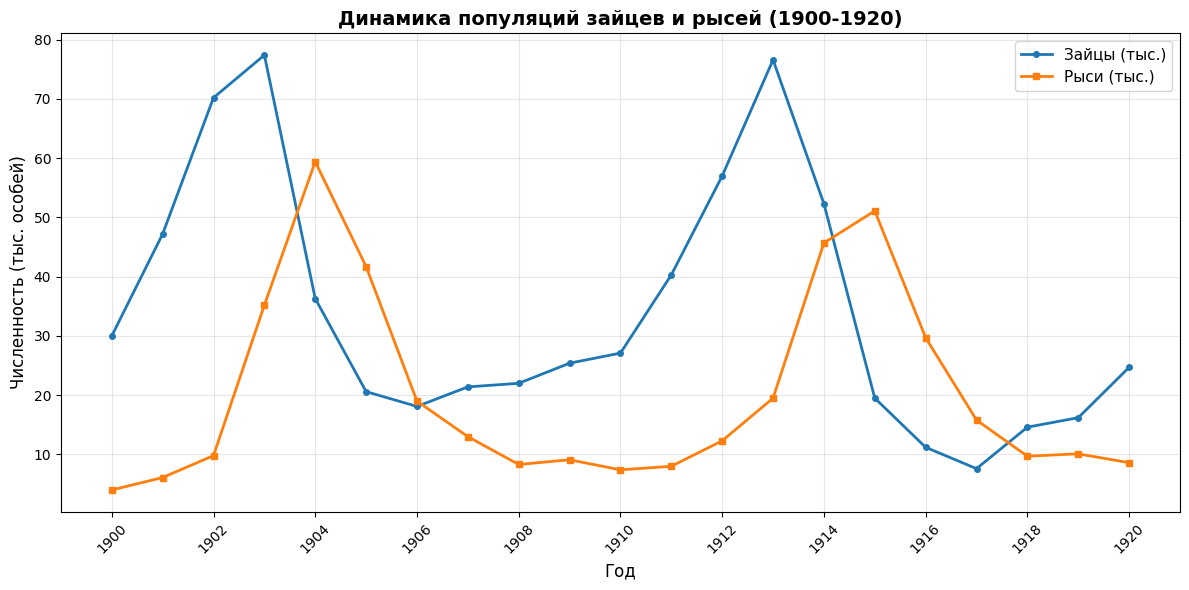

In [5]:
plt.figure(figsize=(12, 6))

plt.plot(t_data, H_data, marker="o", linewidth=2, markersize=4, label="Зайцы (тыс.)")
plt.plot(t_data, L_data, marker="s", linewidth=2, markersize=4, label="Рыси (тыс.)")

plt.title(
    f"Динамика популяций зайцев и рысей ({t_data[0]}-{t_data[-1]})",
    fontsize=14,
    fontweight="bold",
)
plt.xlabel("Год", fontsize=12)
plt.ylabel("Численность (тыс. особей)", fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

plt.xticks(df["Year"][::2], rotation=45)

plt.tight_layout()


plt.show()

# Calculation

## Params calculation

In [6]:
initial_guess = [1.0, 0.1, 0.01, 0.375]
bounds = [(0.001, 10), (0.001, 1), (0.001, 1), (0.001, 1)]

result = minimize(objective, initial_guess, args=(data, y0), bounds=bounds, method="L-BFGS-B")
params = result.x
alpha, beta, delta, gamma = params

In [7]:
alpha, beta, delta, gamma

(np.float64(0.5667049385112378),
 np.float64(0.029078193684565372),
 np.float64(0.025746115344867877),
 np.float64(0.8129026127951081))

## Calculation on hystorical data

In [8]:
H0 = df[P_col_name].iloc[0]
L0 = df[H_col_name].iloc[0]
t_span = (df[t_col_name].iloc[0], df[t_col_name].iloc[-1])
n_steps = 1000
y0 = [H0, L0]
t_rk, y_rk = runge_kutta_4th_order(lotka_volterra, y0, t_span, n_steps, params)

# Visualisation

[]

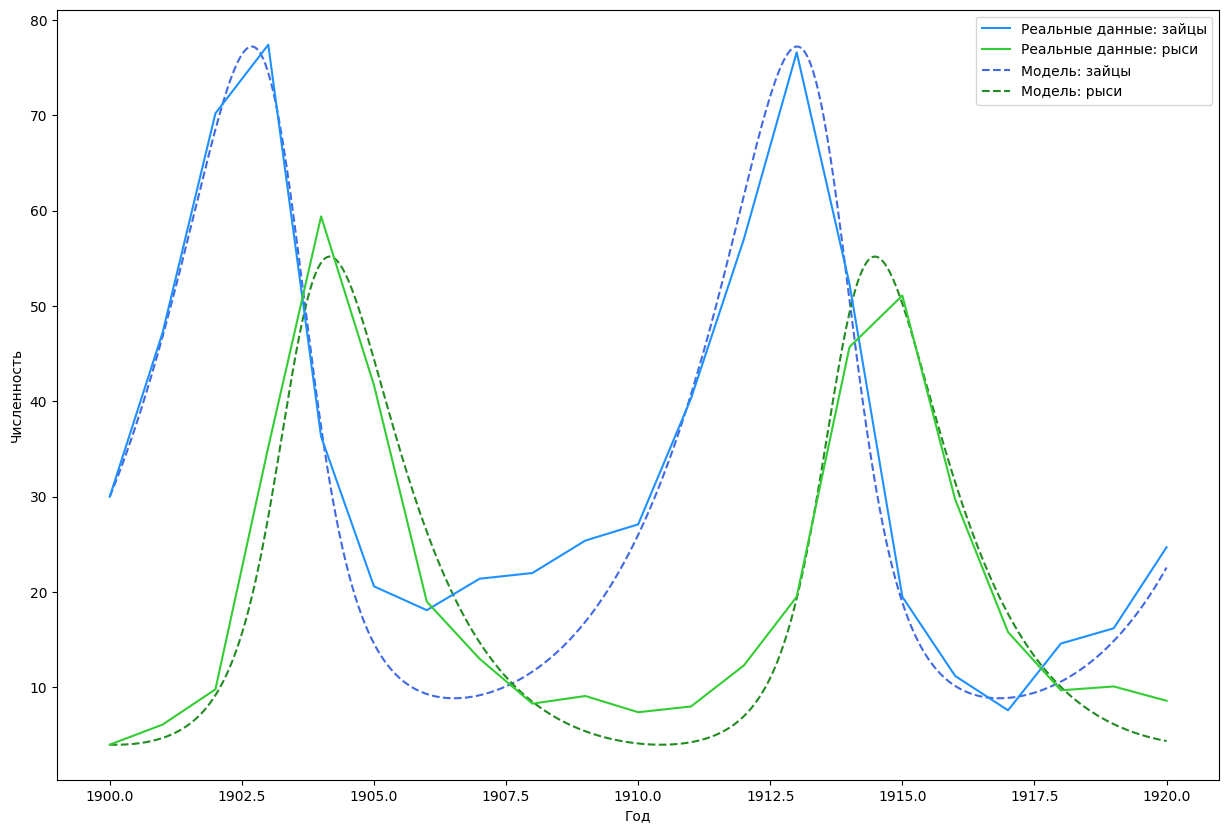

In [9]:
# Визуализация результатов
plt.figure(figsize=(15, 10))
plt.plot(
    df[t_col_name],
    df[P_col_name],
    "dodgerblue",
    label="Реальные данные: зайцы",
    zorder=2,
)
plt.plot(
    df[t_col_name], df[H_col_name], "limegreen", label="Реальные данные: рыси", zorder=2
)
plt.plot(t_rk, y_rk[0], "royalblue", linestyle="--", label="Модель: зайцы", zorder=1)
plt.plot(t_rk, y_rk[1], "forestgreen", linestyle="--", label="Модель: рыси", zorder=1)
plt.legend()
plt.xlabel("Год")
plt.ylabel("Численность")
plt.plot()


[]

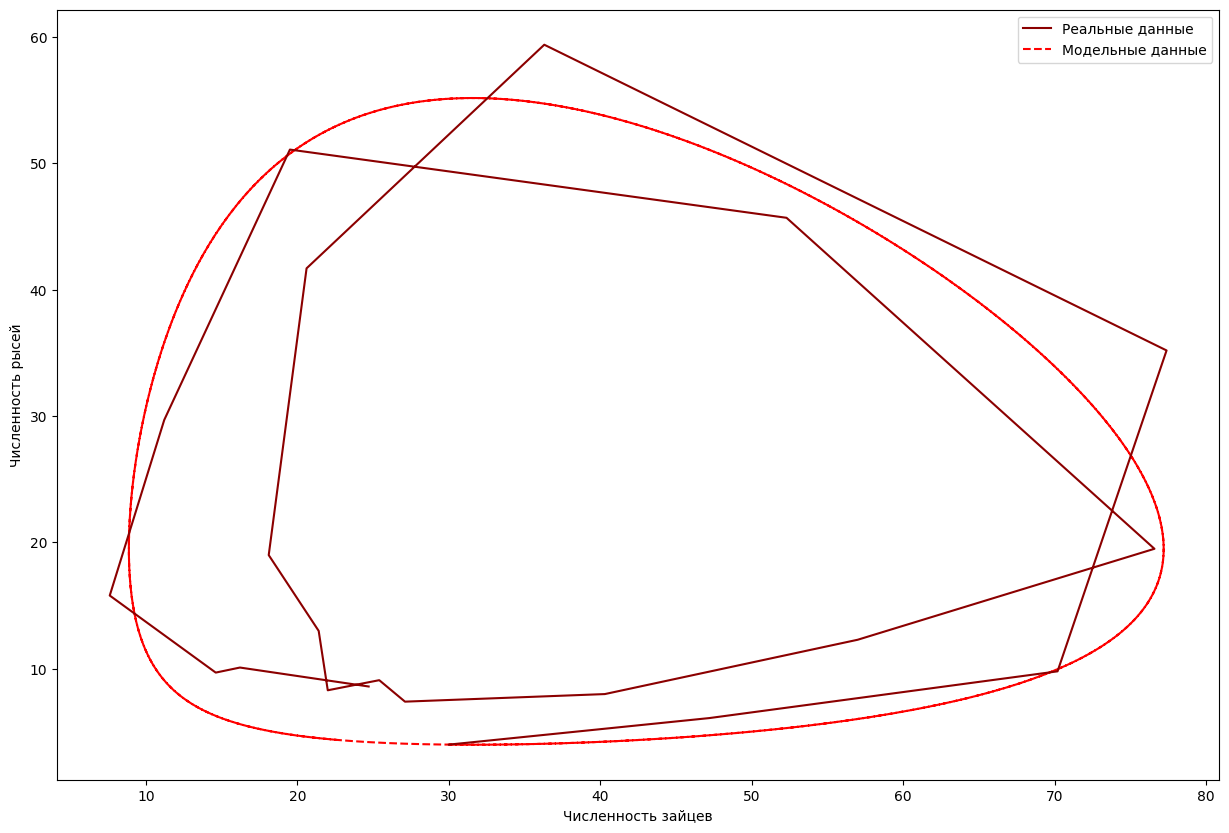

In [10]:
# Фазовый портрет
plt.figure(figsize=(15, 10))
plt.plot(df[P_col_name], df[H_col_name], "darkred", label="Реальные данные", zorder=2)
plt.plot(y_rk[0], y_rk[1], "red", linestyle="--", label="Модельные данные", zorder=1)
plt.legend()
plt.xlabel("Численность зайцев")
plt.ylabel("Численность рысей")
plt.plot()

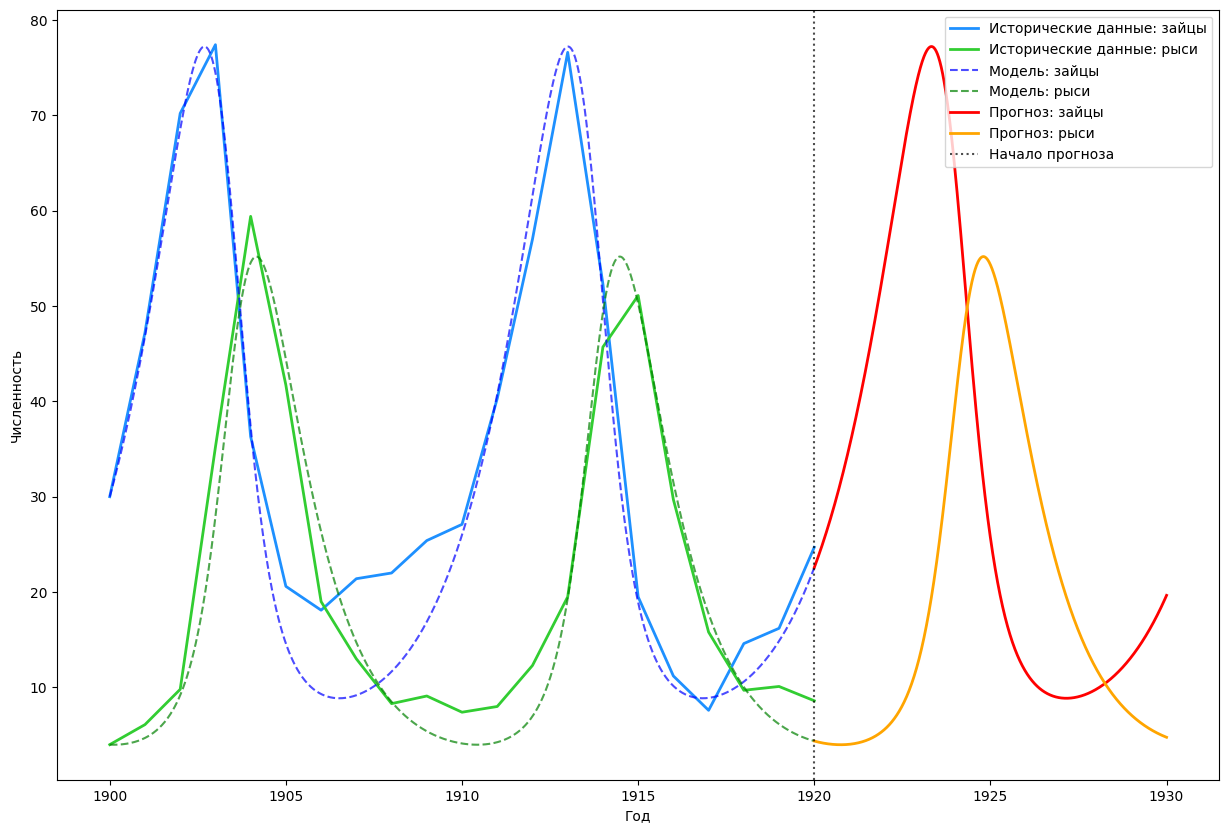

In [11]:
H0_forecast = y_rk[0][-1]
L0_forecast = y_rk[1][-1]
last_year = df[t_col_name].iloc[-1]
# Период прогноза
forecast_years = 10
t_span_forecast = (last_year, last_year + forecast_years)
n_steps_forecast = 1000
# Прогноз с использованием последних известных значений
t_forecast, y_forecast = runge_kutta_4th_order(
    lotka_volterra,
    [H0_forecast, L0_forecast],
    t_span_forecast,
    n_steps_forecast,
    params,
)
# Визуализация прогноза
plt.figure(figsize=(15, 10))
# Исторические данные
plt.plot(
    df[t_col_name],
    df[P_col_name],
    "dodgerblue",
    label="Исторические данные: зайцы",
    linewidth=2,
)
plt.plot(
    df[t_col_name],
    df[H_col_name],
    "limegreen",
    label="Исторические данные: рыси",
    linewidth=2,
)
# Модель на историческом периоде
plt.plot(t_rk, y_rk[0], "blue", linestyle="--", label="Модель: зайцы", alpha=0.7)
plt.plot(t_rk, y_rk[1], "green", linestyle="--", label="Модель: рыси", alpha=0.7)
# Прогноз
plt.plot(
    t_forecast, y_forecast[0], "red", linestyle="-", label="Прогноз: зайцы", linewidth=2
)
plt.plot(
    t_forecast,
    y_forecast[1],
    "orange",
    linestyle="-",
    label="Прогноз: рыси",
    linewidth=2,
)
# Вертикальная линия разделяющая историю и прогноз
plt.axvline(
    x=last_year, color="black", linestyle=":", alpha=0.7, label="Начало прогноза"
)
plt.legend()
plt.xlabel("Год")
plt.ylabel("Численность")
plt.show()